In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("l33tc0d3r/indian-food-classification")

print("Path to dataset files:", path)

100%|██████████| 1.48G/1.48G [00:52<00:00, 30.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/l33tc0d3r/indian-food-classification/versions/1


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.preprocessing import image

In [ ]:
image_dir = Path('/root/.cache/kagglehub/datasets/l33tc0d3r/indian-food-classification/versions/1')
#The path to the image directory was incorrect.
#Changing it to the correct path solves the issue
#The glob function was looking for files in the wrong directory
#It should be looking for files in /kaggle/input/indian-food-classification/Food Classification
#The incorrect path is ../input/indian-food-classification/Food Classification

**Creating file dataframe**

In [ ]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
#using glob to target particular image files

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
#separating the class names from the file paths and saving in labels

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(130, random_state=1))
#concatenate category samples
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)



In [ ]:
image_df['Label'].value_counts()

,count
Label,
dhokla,130
chapati,130
kadai_paneer,130
masala_dosa,130
jalebi,130
chai,130
pakode,130
butter_naan,130
samosa,130


**train-test split**

In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)
#70% training 30% test
#since we are shuffling, random state = 1

**creating generators**

In [ ]:
#limited memory so we train in batches to recycle memory
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

We are using a pre-trained model mobilenetV2 from tensorflow which is a CNN architecture.
https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c


In [ ]:
#this train_images will be passed into our fit function
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
#default image size for mobilenetV2 is 224x224
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
#shuffle after each epoch
    seed=42,
    subset='training'
#only available if validation_split is used to specify whether to use validation subset 0.2 or training subset

)

validation_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1456 validated image filenames belonging to 20 classes.
Found 363 validated image filenames belonging to 20 classes.
Found 781 validated image filenames belonging to 20 classes.


**modeling**

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
#we dont wanna keep the classification layer of the og dataset on which the model is pretrained we just want our dataset's classification layer
#originally trained on imagenet  dataset 1000 classes
    weights='imagenet',
#to keep the same weights
    pooling='avg'
#output is 1d now
)

pretrained_model.trainable = False
#to not change the original imagenet weights
#We are transfering learning of the model so we keep it as it is
#This model is good for feature extraction
#Use the same model, remove the top layer, use your own top layer i.e. classes, dataset

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
#128 neurons
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(20, activation='softmax')(x)
#classification layer
model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,441,044 (9.31 MB)

 Trainable params: 183,060 (715.08 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


**training**

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    #as classes are encoded as vectors by the generator so we use categorical_crossentropy
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=10,
    #INCREASE NO. OF EPOCHS TO INCREASE ACCURACY (77.46% ACCURACY ACHIEVED ON 100 EPOCHS)
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='validation_loss',
            patience=3,
            #when validation loss stops improving for 3 consecutive epochs training will be stopped and best epochs weights are restored
            restore_best_weights=True,
            mode='min' # Add this line to specify the mode
        )
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.2636 - loss: 2.5655 - val_accuracy: 0.6419 - val_loss: 1.1454
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `validation_loss` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7670 - loss: 0.8115 - val_accuracy: 0.7328 - val_loss: 0.8934
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8859 - loss: 0.4509 - val_accuracy: 0.7190 - val_loss: 0.8543
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9173 - loss: 0.2929 - val_accuracy: 0.7741 - val_loss: 0.7552
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9589 - loss: 0.1692 - val_accuracy: 0.7796 - val_loss: 0.7213
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9905 - loss: 0.1030 - val_accuracy: 0.7769 - val_loss: 0.7422
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9969 - loss: 0.0589 - val_accuracy: 0.7796 - val_loss: 0.6879
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9989 - loss: 0.0347 - val_accuracy: 0.7769 - val_loss: 0.7224
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 1.0000 - loss: 0.0175 - val_accuracy: 0.7961 - val_loss: 0.6903
E

**results**

In [ ]:
results = model.evaluate(test_images, verbose=0)
#gives loss and accuracy for test set
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 79.26%


**predictions**

In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step


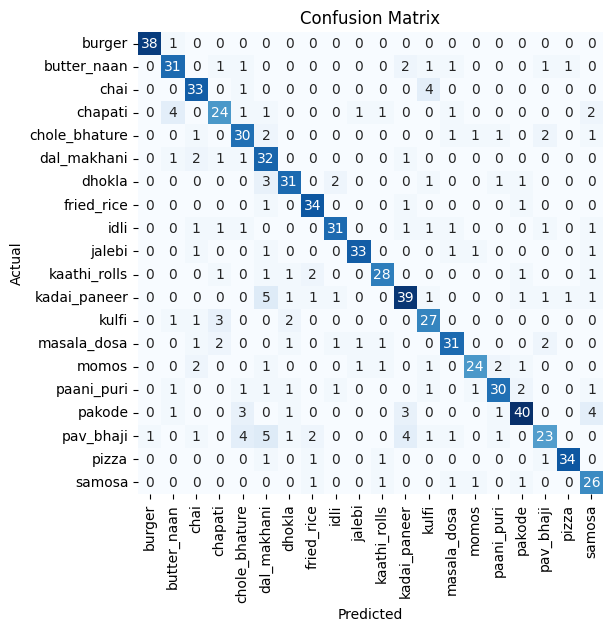

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

       burger       0.97      0.97      0.97        39
  butter_naan       0.78      0.79      0.78        39
         chai       0.77      0.87      0.81        38
      chapati       0.73      0.69      0.71        35
chole_bhature       0.70      0.77      0.73        39
  dal_makhani       0.59      0.84      0.70        38
       dhokla       0.79      0.79      0.79        39
   fried_rice       0.83      0.92      0.87        37
         idli       0.86      0.79      0.83        39
       jalebi       0.92      0.87      0.89        38
 kaathi_rolls       0.85      0.80      0.82        35
 kadai_paneer       0.76      0.75      0.76        52
        kulfi       0.71      0.79      0.75        34
  masala_dosa       0.82      0.78      0.79        40
        momos       0.86      0.73      0.79        33
   paani_puri       0.83      0.75      0.79        40
       pakode    

In [ ]:
import pickle

# Suppose your model variable is called 'model'
with open('food_model.pkl', 'wb') as f:
    pickle.dump(model,f)

In [ ]:
model.save('food_model.h5')

In [ ]:
from google.colab import files
files.download('food_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class_names = image_df['Label'].unique().tolist()
print(class_names)

['dhokla', 'chapati', 'kadai_paneer', 'masala_dosa', 'jalebi', 'chai', 'pakode', 'butter_naan', 'samosa', 'idli', 'kaathi_rolls', 'paani_puri', 'fried_rice', 'kulfi', 'momos', 'dal_makhani', 'pav_bhaji', 'burger', 'pizza', 'chole_bhature']
